In [16]:
import time 
from qutip import mesolve, steadystate
import numpy as np
import optical as EM
import phonons as RC
import leads as FL
from utils import *
from style import *
from photocell_setup import *
from importlib import reload

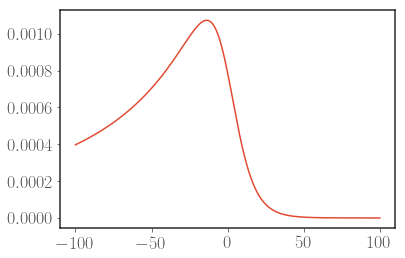

In [2]:
w = np.linspace(-100, 100, 1000)
plt.plot(w, FL.J_Lorentzian(w, 10, 100, Gamma=1)*FL.fermi_occ(w, 10, 0.) )
#plt.plot(w, FL.J_Lorentzian(w, 10,100,Gamma=1)*(1-FL.fermi_occ(w, 10, 0.)))
#plt.plot(w, J_underdamped(w, 10,10,alpha=1/(2*pi)) )
plt.show()

In [135]:
reload(RC)
reload(EM)
reload(FL)

def dynamics( H, L, PARAMS, tf=10, tN=1000):
    timelist = np.linspace(0, tf, tN)
    ops = make_expectation_operators(PARAMS)
    rho_0 = tensor(0.5*(exciton_ket+vac_ket)*(exciton_ket.dag()+vac_ket.dag()), 
                   thermal_dm(PARAMS['N'], Occupation(PARAMS['Omega_RC'], PARAMS['T_ph'])))
    data = mesolve(H, rho_0, timelist, c_ops=[L], e_ops=[ops['exciton'], ops['real_coherence'], 
                                                         ops['imag_coherence']], 
                   options=qt.Options(nsteps=15000))
    plt.figure()
    plt.plot(timelist, data.expect[0])
    plt.figure()
    plt.plot(timelist, data.expect[1])
    plt.show()

def build_full_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
    
    #  Left and right leads and additive
    #L_L, L_R = FL.L_R_lead_dissipators(H_S, PARAMS, real_only=False, silent=False)
    L_L, L_R = FL.L_R_lead_dissipators(H, PARAMS, silent=silent)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R': L_R, 
                                            'L_full' : L_EM+L_L+L_R+L_RC}
    return L_dict # dict

def build_Lindblad_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
    
    #  Left and right leads and additive
    #L_L, L_R = FL.L_R_lead_dissipators(H_S, PARAMS, real_only=False, silent=False)
    L_L, L_R = L_left_and_right_secular(H, PARAMS)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R': L_R, 
                                            'L_lindblad' : L_EM+L_L+L_R+L_RC}
    return L_dict # dict

def build_all_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
        L_EM_add = EM.L_non_rwa(H_add, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                                PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
    
    #  Left and right leads and additive
    L_L, L_R = FL.L_R_lead_dissipators(H, PARAMS, silent=silent)
    L_L_lindblad, L_R_lindblad = L_left_and_right_secular(H, PARAMS)
    L_L_add, L_R_add = FL.L_left_nonadditive(H_add, PARAMS), FL.L_right_nonadditive(H_add, PARAMS)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R': L_R, 'L_R_lindblad': L_R_lindblad,
                                            'L_full' : L_EM+L_L+L_R+L_RC,
                                            'L_lindblad' : L_EM+L_L_lindblad+L_R_lindblad+L_RC,
                                            'L_add_EM' : L_EM_add+L_R+L_L+L_RC,
                                            'L_add_leads' : L_EM+L_L_add+L_R_add+L_RC,
                                            'L_no_EM' : L_R+L_L+L_RC}
    return L_dict # dict
#return H_S, L_RC, L_EM, L_EM_add, L_L, L_R, L_L_add, L_R_add



In [178]:
def L_left_and_right_electronic(PARAMS):
    ti = time.time()
    energies, states = PARAMS['H_sub'].eigenstates()
    A_R = d_e
    A_L = d_h
    H_dim = len(energies)
    Lambda_up_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='p', real_only=True)
    Lambda_down_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='m', real_only=True)
    
    Lambda_up_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='p', real_only=True)
    Lambda_down_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='m', real_only=True)
    
    L_L = L_R = 0
    for j in range(H_dim):
        for k in range(H_dim):
            omega_jk = energies[j]-energies[k]
            state_j, state_k = states[j], states[k]
            
            A_dag_jk = A_R.dag().matrix_element(state_j, state_k)
            A_kj = A_R.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_R += Lambda_down_R(omega_jk)*coeff*secular_term(state_j, state_k)
                L_R += Lambda_up_R(omega_jk)*coeff*secular_term(state_k, state_j)
            
            A_dag_jk = A_L.dag().matrix_element(state_j, state_k)
            A_kj = A_L.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_L += Lambda_down_L(-omega_jk)*coeff*secular_term(state_j, state_k)
                L_L += Lambda_up_L(-omega_jk)*coeff*secular_term(state_k, state_j)
    #print(time.time() - ti)
    return L_L, L_R

In [192]:
PARAMS = PARAMS_setup(binding_energy=0.0, radiative_lifetime=np.infty, alpha_ph=0, mu_L=0.0, 
                      bias_voltage=0., N=8, silent=False)
L_L, L_R = L_left_and_right_electronic(PARAMS)
print(L_L.eigenenergies())
steadystate(PARAMS['H_sub'], [L_L+L_R])

Phonon occupation: 2.12. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=8.
[-0.0026545 +0.j -0.0026545 +0.j -0.0026545 +0.j -0.0026545 +0.j
 -0.00132725+0.j -0.00132725+0.j -0.00132725+0.j -0.00132725+0.j
 -0.00132725+0.j -0.00132725+0.j -0.00132725+0.j -0.00132725+0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]


Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [81]:
def secular_term(state_j, state_k):
    jk = state_j*state_k.dag()
    kj = jk.dag()
    jj = state_j*state_j.dag()
    return sprepost(kj, jk) - 0.5*(spre(jj) + spost(jj))

def L_left_and_right_secular(H, PARAMS):
    ti = time.time()
    energies, states = H.eigenstates()
    A_R = L_dict['PARAMS']['A_R']
    A_L = L_dict['PARAMS']['A_L']
    H_dim = len(energies)
    Lambda_up_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='p', real_only=True)
    Lambda_down_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='m', real_only=True)
    
    Lambda_up_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='p', real_only=True)
    Lambda_down_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='m', real_only=True)
    
    L_L = L_R = 0
    for j in range(H_dim):
        for k in range(H_dim):
            omega_jk = energies[j]-energies[k]
            state_j, state_k = states[j], states[k]
            
            A_dag_jk = A_R.dag().matrix_element(state_j, state_k)
            A_kj = A_R.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_R += Lambda_down_R(omega_jk)*coeff*secular_term(state_j, state_k)
                L_R += Lambda_up_R(omega_jk)*coeff*secular_term(state_k, state_j)
            
            A_dag_jk = A_L.dag().matrix_element(state_j, state_k)
            A_kj = A_L.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_L += Lambda_down_L(-omega_jk)*coeff*secular_term(state_j, state_k)
                L_L += Lambda_up_L(-omega_jk)*coeff*secular_term(state_k, state_j)
    #print(time.time() - ti)
    return L_L, L_R

In [177]:
PARAMS = PARAMS_setup(binding_energy=0.0, radiative_lifetime=np.infty, alpha_ph=0, mu_L=0.0, 
                      bias_voltage=0, N=3, silent=False)
L_dict = build_all_L(PARAMS)
print_PARAMS(PARAMS)
print(L_dict['L_lindblad'].eigenenergies())
ss = steadystate(L_dict['H_S'], [L_dict['L_lindblad']])
print(ss.ptrace(0))
#n_e = d_e.dag()*d_e
#print((ss.ptrace(0))*n_e)
#print(qt.vector_to_operator(L_dict['L_R_lindblad']*qt.operator_to_vector(ss)).ptrace(0))
#print( (qt.vector_to_operator(L_dict['L_R_lindblad']*qt.operator_to_vector(ss))*tensor(n_e, qeye(5))).tr() )

Phonon occupation: 2.12. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=3.
omega_c : 8065.5	omega_v : 8065.5	omega_exciton : 16131.0	Gamma_EM : 0.0	alpha_ph : 0.0	Gamma_ph : 8.0655	Omega_ph : 80.655	T_ph : 300.0	deformation_ratio : 0.5	N : 3	Gamma_L : 0.005309	Gamma_R : 0.005309	delta_L : 24.1965	delta_R : 24.1965	Omega_L : -8065.5	Omega_R : 8065.5	mu_L : 0.0	mu_R : 0.0	T_L : 300.0	T_R : 300.0	T_EM : 5800	J : <function J_minimal at 0x10a290950>	leads_lifetime : 1	radiative_lifetime : inf	binding_energy : 0.0	sys_dim : 4	Omega_RC : 80.655	gamma_RC : 0.015915494309189534	kappa_RC : 0.0	energy_shift : 0.0
[-1.25980879e+02-7.79331546e-15j -1.25980873e+02+3.35361556e-25j
 -1.25980873e+02+1.58738207e-24j -1.25980866e+02-3.73468517e-26j
 -1.25980862e+02+4.44524890e-22j -1.25980862e+02-1.17983097e-22j
 -1.25980862e+02-9.55211594e-25j -1.25980862e+02+7.70083742e-15j
 -1.25980856e+02-5.67430680e-21j -1.25980856e+02-7.39771630e-25j
 -1.25980856e+02+5.03722023e-17j -1.25980856e+

In [111]:

#-(qt.vector_to_operator(L_track*qt.operator_to_vector(rho_ss))*obs_ops[0]).tr()

(0.0025591739128779448+8.006703042413383e-09j)

In [ ]:
300*0.695/ev_to_inv_cm

In [72]:
PARAMS = PARAMS_setup(binding_energy=0.0, radiative_lifetime=1, alpha_ph=0., mu_L=0.03, 
                      bias_voltage=0, N=4, silent=False)
L_dict = build_all_L(PARAMS)
print_PARAMS(PARAMS)
"""
ss = steadystate(L_dict['H_S'], [L_dict['L_full']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_add_EM']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_add_leads']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_no_EM']])
print(ss.ptrace(0))"""

Phonon occupation: 2.12. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=4.
0.0772712230682373
[-2.43753501e-08+0.j -2.43753501e-08+0.j -2.00981816e-08+0.j
 -2.00981816e-08+0.j -1.21876750e-08+0.j -1.21876750e-08+0.j
 -1.21876750e-08+0.j -1.21876750e-08+0.j -1.21876750e-08+0.j
 -1.21876750e-08+0.j -1.21876750e-08+0.j -1.21876750e-08+0.j
 -1.00490908e-08+0.j -1.00490908e-08+0.j -1.00490908e-08+0.j
 -1.00490908e-08+0.j -1.00490908e-08+0.j -1.00490908e-08+0.j
 -1.00490908e-08+0.j -1.00490908e-08+0.j -1.00490908e-08+0.j
 -1.00490908e-08+0.j -1.00490908e-08+0.j -1.00490908e-08+0.j
 -1.00490908e-08+0.j -1.00490908e-08+0.j -1.00490908e-08+0.j
 -1.00490908e-08+0.j -1.00490908e-08+0.j -1.00490908e-08+0.j
 -1.00490908e-08+0.j -1.00490908e-08+0.j -1.00490908e-08+0.j
 -1.00490908e-08+0.j -1.00490908e-08+0.j -1.00490908e-08+0.j
 -1.00490908e-08+0.j -1.00490908e-08+0.j -1.00490908e-08+0.j
 -1.00490908e-08+0.j -1.00490908e-08+0.j -1.00490908e-08+0.j
 -1.00490908e-08+0.j -1.00490908e

omega_c : 8065.5	omega_v : 8065.5	omega_exciton : 16131.0	Gamma_EM : 0.005309	alpha_ph : 0.0	Gamma_ph : 8.0655	Omega_ph : 80.655	T_ph : 300.0	deformation_ratio : 0.5	N : 4	Gamma_L : 0.005309	Gamma_R : 0.005309	delta_L : 24.1965	delta_R : 24.1965	Omega_L : -8065.5	Omega_R : 8065.5	mu_L : 241.965	mu_R : 241.965	T_L : 300.0	T_R : 300.0	T_EM : 5800	J : <function J_minimal at 0x10a290950>	leads_lifetime : 1	radiative_lifetime : 1	binding_energy : 0.0	sys_dim : 4	Omega_RC : 80.655	gamma_RC : 0.015915494309189534	kappa_RC : 0.0	energy_shift : 0.0


"\nss = steadystate(L_dict['H_S'], [L_dict['L_full']])\nprint(ss.ptrace(0))\nss = steadystate(L_dict['H_S'], [L_dict['L_add_EM']])\nprint(ss.ptrace(0))\nss = steadystate(L_dict['H_S'], [L_dict['L_add_leads']])\nprint(ss.ptrace(0))\nss = steadystate(L_dict['H_S'], [L_dict['L_no_EM']])\nprint(ss.ptrace(0))"

In [ ]:
PARAMS = PARAMS_setup(binding_energy=0.1, radiative_lifetime=1, alpha_ph=100e-3, mu_L=0.0, 
                      bias_voltage=0.5, N=14, silent=False)
L_dict = build_all_L(PARAMS)
print_PARAMS(PARAMS)
ss = steadystate(L_dict['H_S'], [L_dict['L_full']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_add_EM']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_add_leads']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_no_EM']])
print(ss.ptrace(0))

In [123]:
def current_from_L(L_dict, n_c_RC):
    obs_out = []
    ss = steadystate(L_dict['H_S'], [L_dict['L_lindblad']])
    n_e = d_e.dag()*d_e
    return (qt.vector_to_operator(L_dict['L_R']*qt.operator_to_vector(ss))*tensor(n_e, qeye(5))).tr()

def current_and_obs_from_L(H, L_full, L_track, obs_ops):
    obs_out = []
    rho_ss = qt.steadystate(H, [L_full])
    obs_out.append(-(qt.vector_to_operator(L_track*qt.operator_to_vector(rho_ss))*obs_ops[0]).tr())
    for obs in obs_ops[1::]:
        obs_out.append((rho_ss*obs).tr())
    del rho_ss
    return obs_out

def simple_current_voltage(PARAMS):
    bias_voltages = np. linspace(0, PARAMS['omega_exciton']*1.2, 100)
    
    currents = []
    for i, bv in enumerate(bias_voltages):
        PARAMS.update({'mu_R': PARAMS['mu_L']+bv})
        if i in [10, 30, 50, 90]:
            print_PARAMS(PARAMS)
        L_Lindblad_dict = build_Lindblad_L(PARAMS, silent=True)
        ops = make_expectation_operators(PARAMS)
        #d_e_RC = ops['d_e']
        #n_c = d_e_RC.dag()*d_e_RC
        n_c = tensor(d_e.dag()*d_e, qeye(PARAMS['N']))
        currents.append(current_from_L(L_dict, n_c))
    return bias_voltages, currents




In [127]:
PARAMS = PARAMS_setup(binding_energy=0.0, leads_lifetime=2, radiative_lifetime=1, 
                      alpha_ph=0, mu_L=0, bias_voltage=0, N=4, silent=False)
PARAMS = PARAMS_setup(binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu_L=0.0, 
                      bias_voltage=0, N=5, silent=False)
V_values, I = simple_current_voltage(PARAMS)

Phonon occupation: 2.12. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=4.
Phonon occupation: 2.12. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
omega_c : 8065.5	omega_v : 8065.5	omega_exciton : 16131.0	Gamma_EM : 0.005309	alpha_ph : 0.0	Gamma_ph : 8.0655	Omega_ph : 80.655	T_ph : 300.0	deformation_ratio : 0.5	N : 5	Gamma_L : 0.005309	Gamma_R : 0.005309	delta_L : 24.1965	delta_R : 24.1965	Omega_L : -8065.5	Omega_R : 8065.5	mu_L : 0.0	mu_R : 1955.2727272727273	T_L : 300.0	T_R : 300.0	T_EM : 5800	J : <function J_minimal at 0x10a290950>	leads_lifetime : 1	radiative_lifetime : 1	binding_energy : 0.0	sys_dim : 4	Omega_RC : 80.655	gamma_RC : 0.015915494309189534	kappa_RC : 0.0	energy_shift : 0.0
omega_c : 8065.5	omega_v : 8065.5	omega_exciton : 16131.0	Gamma_EM : 0.005309	alpha_ph : 0.0	Gamma_ph : 8.0655	Omega_ph : 80.655	T_ph : 300.0	deformation_ratio : 0.5	N : 5	Gamma_L : 0.005309	Gamma_R : 0.005309	delta_L : 24.1965	delta_R : 24.1965	Omega_L : -80

In [128]:
I

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

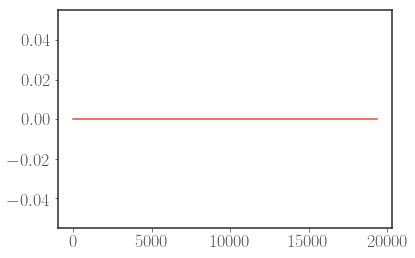

In [125]:
plt.plot(V_values, np.array(I).real)
plt.show()

In [ ]:
plt.plot(V_values, I)
plt.show()

In [ ]:
PARAMS